### Part 2: Modern Portfolio Theory *[15 points]*

In Lecture 7, we learn how to conduct backtesting and solve for optimal portfolios numerically. Now, you have to compare the **out-of-sample performance** of **analytical optimal portfolios** and **numerical constrained portfolios**. Your code should do the following:

1. Using **Fama-French 17 Industries Portfolios from 1980 until 2021**, conduct back-testing on the following strategies *[12.5 points]*:
    * **MSRP (analytical)** *[2.5 points]*;
    * **GMVP (analytical)** *[2.5 points]*; 
    * **MSRP no short-selling (numerical)** *[2.5 points]*; 
    * **GMVP no short-selling (numerical)** *[2.5 points]*; 
    * **Equal-weighted (EW) portfolio** *[2.5 points]*.
2. Plot the **cumulative returns** of **all five strategies** *[2.5 points]*.

#### Bonus *[15 points]*:
1. **Apply shrinkage method** to estimate **expected returns** and **variance-covariance matrices** *[5 points]*.
2. **Reduce computation time** through **parallel computing** *[10 points]*.

----

## Step1: Analytical MSRP, GMVP

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
cmap = sns.color_palette() # plaette: 調色板

In [2]:
factor = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1-1-1926')
asset = pdr.get_data_famafrench('10_Industry_Portfolios', start='1-1-1926')
start_year = '1980'
end_year = '2021'

In [3]:
asset[0].shape # 17 industries

(1144, 10)

In [4]:
# 取得月度 factor 資料 與 月度報酬資料
df_FF = factor[0].loc[start_year:end_year]
df_R = asset[0].loc[start_year:end_year] 

In [5]:
df_FF.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1980-01,5.51,1.62,1.75,0.80
1980-02,-1.22,-1.85,0.61,0.89
1980-03,-12.90,-6.64,-1.01,1.21
1980-04,3.97,1.05,1.08,1.26
1980-05,5.26,2.13,0.38,0.81


In [6]:
# ER = Excessive Return = Return - Risk free return
df_ER = df_R.subtract(df_FF.RF,axis=0).shift(1) # lag one month

In [7]:
#  analytical closed-form
def gmvp(S):
    ONE = np.ones(len(S))
    return (inv(S) @ ONE) / (ONE.T @ inv(S) @ ONE)

def msrp(ER, S):
    ONE = np.ones(len(S))
    return (inv(S) @ ER) / (ONE.T @ inv(S) @ ER)
        
def pret(w, R):
    return (w @ R)

## Step2: Numerical MSRP, GMVP

### First Guess

Objective functions:  
- GMVP:
$$\sigma^2_p = W^T\sum W \ s.t. W^T 1 = 1$$  

- $$SR_p = \frac{W^TR} {\sqrt (W^T\sum W}\ s.t. W^T 1 = 1$$

In [8]:
# define objective functions
def pvar(w, S):
    return (w @ S @ w)
def pret(w, ER):
    return (w @ ER)
def sharpe(w, ER, S):
    return -(w @ ER)/np.sqrt(w @ S @ w)

In [9]:
S = df_R.cov()
R = df_R.mean(axis=0)
ER = df_ER.mean(axis=0)
N = len(ER)
ONE = np.ones(len(ER))
GMVP = (inv(S) @ ONE) / (ONE.T @ inv(S) @ ONE)
MSRP = (inv(S) @ ER) / (ONE.T @ inv(S) @ ER)

first guess:   
$w_i = \frac{1}{N}$

In [10]:
N = len(ER)
x0 = np.ones(N)/N
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1}),
NGMVP = minimize(pvar, x0, method='SLSQP', args=S, constraints=cons, options={'disp': True, 'ftol': 1e-9})

NGMVP.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.49864335488872
            Iterations: 12
            Function evaluations: 146
            Gradient evaluations: 12


array([ 0.21483708, -0.05479385,  0.04232603,  0.04040406,  0.03732582,
        0.13570317,  0.1591965 ,  0.16047633,  0.50421433, -0.23968945])

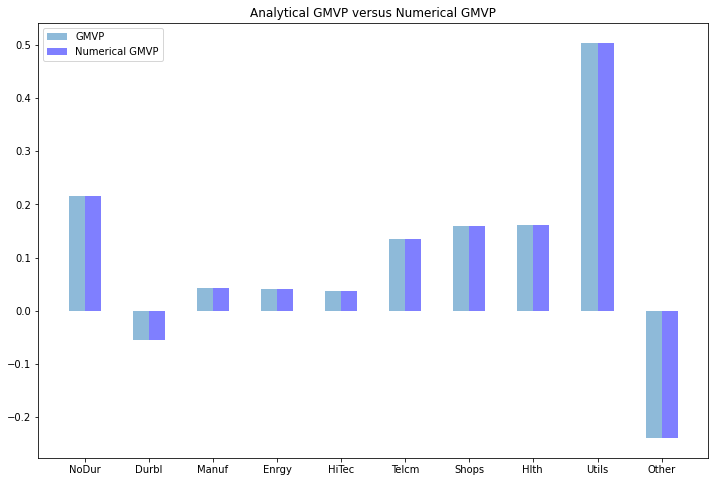

In [11]:
ind = np.arange(N)
plt.figure(figsize=(12, 8))
plt.bar(ind, GMVP, width=0.25, alpha=0.5, color=cmap[0])
plt.bar(ind + 0.25, NGMVP.x, width=0.25, alpha=0.5, color='blue')
plt.xticks(ind + 0.25 / 2, ER.index)
plt.legend(['GMVP','Numerical GMVP'])
plt.title('Analytical GMVP versus Numerical GMVP')


plt.show()

In [12]:
x0 = np.arange(N)/N
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1}),
NMSRP = minimize(sharpe, x0, method='SLSQP', args=(ER, S), constraints=cons, options={'disp': True, 'ftol': 1e-9})

NMSRP.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.23920841302683976
            Iterations: 29
            Function evaluations: 320
            Gradient evaluations: 29


array([ 0.50734515,  0.02408456, -0.05470839,  0.04302867,  0.09852128,
       -0.01034218,  0.35662009,  0.24832195,  0.33203228, -0.54490342])

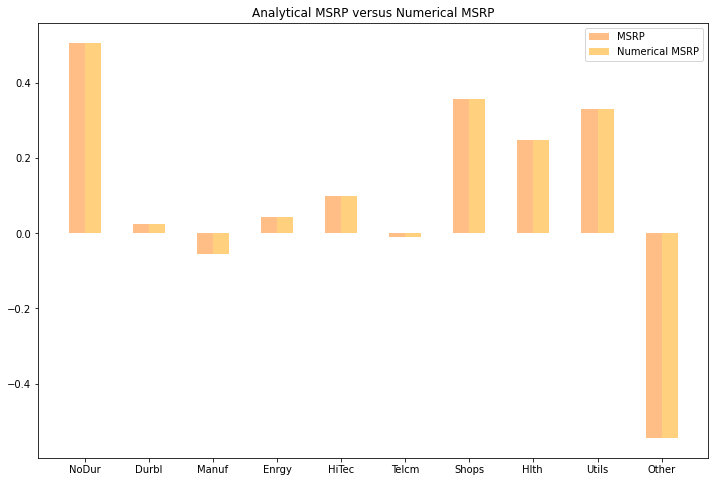

In [13]:
ind = np.arange(N)
plt.figure(figsize=(12, 8))
plt.bar(ind, MSRP, width=0.25, alpha=0.5, color=cmap[1])
plt.bar(ind + 0.25, NMSRP.x, width=0.25, alpha=0.5, color='orange')
plt.xticks(ind + 0.25 / 2, ER.index)
plt.legend(['MSRP','Numerical MSRP'])
plt.title('Analytical MSRP versus Numerical MSRP')
plt.show()


### Numerical GMVP (No shortselling)

In [14]:
from scipy.optimize import Bounds

bounds = Bounds(0, 1) # 標的權重必須介於 0-1

x0 = GMVP
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})
NGMVPnoSS = minimize(pvar, x0, method='SLSQP', constraints=cons, args=S,
options={'disp': True, 'ftol': 1e-9}, bounds=bounds)

NGMVPnoSS


Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.969383643121901
            Iterations: 16
            Function evaluations: 183
            Gradient evaluations: 16


     fun: 11.969383643121901
     jac: array([23.93876827, 28.31171739, 25.25206578, 23.938761  , 23.93879795,
       23.93877792, 23.93877542, 23.93877506, 23.93876171, 27.09893072])
 message: 'Optimization terminated successfully'
    nfev: 183
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([1.77587097e-01, 5.08739463e-15, 6.22484592e-16, 5.11645753e-04,
       6.23766428e-03, 1.04983649e-01, 4.83171275e-02, 1.52472492e-01,
       5.09890324e-01, 1.57054998e-15])

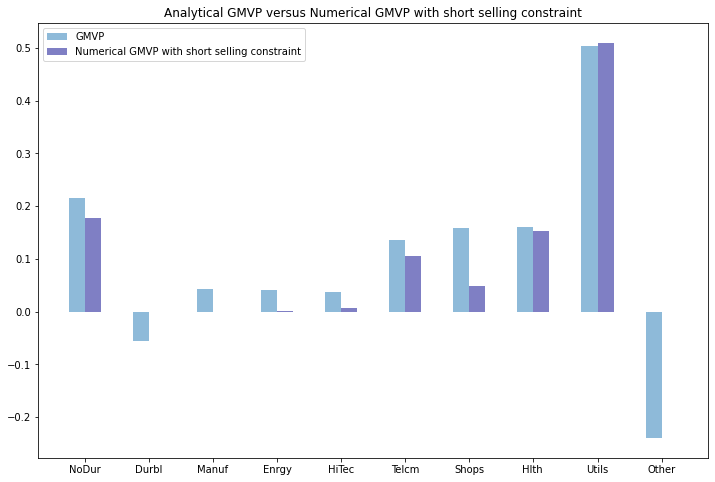

In [15]:
ind = np.arange(N)
plt.figure(figsize=(12, 8))

plt.bar(ind, GMVP, width=0.25, alpha=0.5, color=cmap[0])
plt.bar(ind + 0.25, NGMVPnoSS.x, width=0.25, alpha=0.5, color='darkblue')
plt.xticks(ind + 0.25 / 2, ER.index)
plt.legend(['GMVP','Numerical GMVP with short selling constraint'])
plt.title('Analytical GMVP versus Numerical GMVP with short selling constraint')
plt.show()

### Numerical MSRP (No shortselling)

In [16]:
from scipy.optimize import Bounds
bounds = Bounds(0, 1)
x0 = MSRP
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})
NMSRPnoSS = minimize(sharpe, x0, method='SLSQP', constraints=cons, args=(ER, S),
options={'disp': True, 'ftol': 1e-9}, bounds=bounds)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.22160740816229985
            Iterations: 16
            Function evaluations: 176
            Gradient evaluations: 16


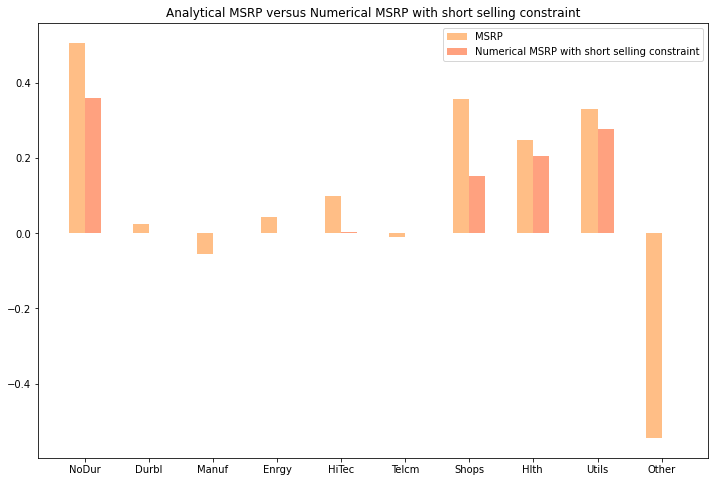

In [17]:
ind = np.arange(N)
plt.figure(figsize=(12, 8))

plt.bar(ind, MSRP, width=0.25, alpha=0.5, color=cmap[1])
plt.bar(ind + 0.25, NMSRPnoSS.x, width=0.25, alpha=0.5, color='orangered')
plt.xticks(ind + 0.25 / 2, ER.index)
plt.legend(['MSRP','Numerical MSRP with short selling constraint'])
plt.title('Analytical MSRP versus Numerical MSRP with short selling constraint')
plt.show()


## Step3: Visualization

In [18]:
df_ER.index

PeriodIndex(['1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06',
             '1980-07', '1980-08', '1980-09', '1980-10',
             ...
             '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
             '2021-07', '2021-08', '2021-09', '2021-10'],
            dtype='period[M]', name='Date', length=502)

In [19]:
Backtest_R.loc['1992-08', 'GMVP']

NameError: name 'Backtest_R' is not defined

In [21]:
NMSRPnoSS.x

array([3.61434576e-01, 0.00000000e+00, 0.00000000e+00, 1.39417388e-17,
       4.37335619e-03, 0.00000000e+00, 1.51640082e-01, 2.04569314e-01,
       2.77982671e-01, 0.00000000e+00])

In [22]:
WSize = 60 # 以 60 個月 rolling
AvgER_rolling = df_ER.rolling(WSize).mean()
CovER_rolling = df_ER.rolling(WSize).cov()

Backtest_R = pd.DataFrame(index=df_R.index,columns=['GMVP','MSRP', 'NGMVPnoSS', 'NMSRPnoSS', 'EW'])


for d in df_ER.index:
    ER = AvgER_rolling.loc[d]
    S = CovER_rolling.loc[d]
    R = df_R.loc[d]
    Backtest_R.loc[d,'GMVP'] = pret(gmvp(S), R)
    Backtest_R.loc[d,'MSRP'] = pret(msrp(ER, S), R)
    Backtest_R.loc[d, 'NGMVPnoSS'] = pret(NGMVPnoSS.x, R)
    Backtest_R.loc[d, 'NMSRPnoSS'] = pret(NMSRPnoSS.x, R)

Backtest_R.loc[:,'EW'] = df_R.mean(axis=1) 
# 增加 equally weighted 的績效，recall df_R column 存放各產業的報酬

Backtest_R = Backtest_R.loc[(df_R.index[0] + WSize):] # delete NaN

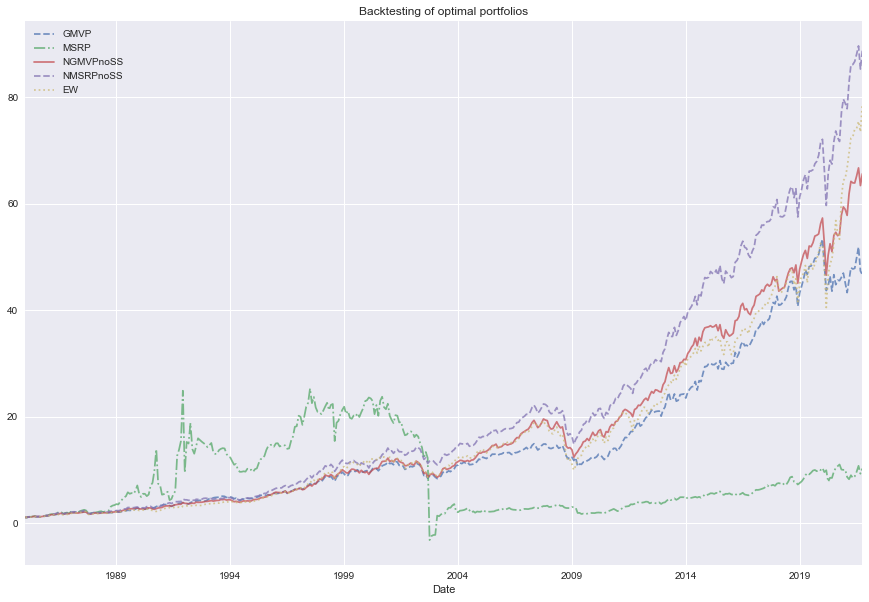

In [23]:
plt.style.use('seaborn')
plt.figure(figsize=(15, 10))

CumRet = (1 + Backtest_R.divide(100)).cumprod()

CumRet['GMVP'].plot(alpha=0.75, linestyle="--")
CumRet['MSRP'].plot(alpha=0.75, linestyle="-.")
CumRet['NGMVPnoSS'].plot(alpha=0.75, linestyle="solid")
CumRet['NMSRPnoSS'].plot(alpha=0.75, linestyle="dashed")
CumRet['EW'].plot(alpha=0.75, linestyle=":")

plt.legend()
plt.title('Backtesting of optimal portfolios')
plt.show()